<a href="https://colab.research.google.com/github/andreidore/recipes/blob/main/recipies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 56.8 MB/s 
     |████████████████████████████████| 895 kB 51.4 MB/s 
     |████████████████████████████████| 3.3 MB 46.3 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [99]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from transformers import AutoTokenizer, TFBertModel, BertConfig

In [61]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
df=pd.read_csv("recipes.csv",sep=";")

In [11]:
df.head()

,Recipe Name,Review Count,Recipe Photo,Author,Prepare Time,Cook Time,Total Time,Ingredients,Directions,RecipeID
0,Golden Crescent Rolls Recipe,304,https://images.media-allrecipes.com/userphotos...,Mike A.,25 m,15 m,3 h 10 m,"yeast,water,white sugar,salt,egg,butter,flour,...","Dissolve yeast in warm water.**Stir in sugar, ...",7000
1,Poppy Seed Bread with Glaze Recipe,137,https://images.media-allrecipes.com/userphotos...,Christina Jun,15 m,1 h,1 h 20 m,"flour,salt,baking powder,poppy,butter,vegetabl...",'Preheat oven to 350 degrees F (175 degrees C)...,7001
2,Applesauce Bread I Recipe,124,https://images.media-allrecipes.com/userphotos...,GAF55,10 m,1 h 20 m,1 h 30 m,"flour,egg,white sugar,vegetable oil,applesauce...",Preheat oven to 350 degrees F (175 degrees C)....,7003
3,Apple Raisin Bread Recipe,39,https://images.media-allrecipes.com/userphotos...,Helen Hanson,15 m,1 h,1 h 15 m,"flour,baking powder,baking soda,salt,cinnamon,...",Preheat oven to 350 degrees F (175 degrees C)....,7006
4,Buttermilk Oatmeal Bread Recipe,41,https://images.media-allrecipes.com/userphotos...,Helen Hanson,10 m,1 h,1 h 40 m,"oat,buttermilk,vegetable oil,egg,brown sugar,f...",Mix oats with buttermilk. Let stand for 1/2 h...,7007


In [13]:
df=df[["Ingredients","Directions"]]
df.head()

,Ingredients,Directions
0,"yeast,water,white sugar,salt,egg,butter,flour,...","Dissolve yeast in warm water.**Stir in sugar, ..."
1,"flour,salt,baking powder,poppy,butter,vegetabl...",'Preheat oven to 350 degrees F (175 degrees C)...
2,"flour,egg,white sugar,vegetable oil,applesauce...",Preheat oven to 350 degrees F (175 degrees C)....
3,"flour,baking powder,baking soda,salt,cinnamon,...",Preheat oven to 350 degrees F (175 degrees C)....
4,"oat,buttermilk,vegetable oil,egg,brown sugar,f...",Mix oats with buttermilk. Let stand for 1/2 h...


In [14]:
df.shape

(12351, 2)

In [39]:
df.dropna(inplace=True)
df.drop_duplicates(subset=["Directions"], inplace=True)


In [40]:
df.shape

(12184, 2)

In [110]:
def filter(w):

  if w.lower in stop_words:
    return False

  if not w.isalpha():
    return False

  if len(w)<=2:
    return False

  if w in ["cup","cups","fluid","ounce","ounces","dash","dashes","gallon","inch",
           "square","inches","thick","make","combine","with","the","bottle",
           "bottled","can","cans","envelope","container","jar","package","packets",
           "packet","pound","pounds","recipe","rinsed","dried","split","steam","tablespoon",
           "tablespoons","teaspoons","teaspoon","and","any"]:
    return False

  return True



def map_ingredient(ingredients):

    word_tokens = word_tokenize(ingredients)
    
    filtered_sentence = [w.lower() for w in word_tokens if filter(w)]

    return " ".join(filtered_sentence)



ingredients= [map_ingredient(item) for ing in df["Ingredients"].values for item in ing.split(",")]
ingredients =[ing for ing in ingredients if len(ing)>0]

#TODO I don't like this
#ingredients=[w for ing in ingredients for w in word_tokenize(ing)]

print(ingredients[0:30])

ingredients= set(ingredients)
print(len(ingredients))
#ingredients

['yeast', 'water', 'white sugar', 'salt', 'egg', 'butter', 'flour', 'butter', 'flour', 'salt', 'baking powder', 'poppy', 'butter', 'vegetable oil', 'egg', 'milk', 'white sugar', 'vanilla', 'almond', 'orange juice', 'butter', 'almond', 'vanilla', 'sugar', 'flour', 'egg', 'white sugar', 'vegetable oil', 'applesauce', 'raisin']
751


In [139]:
def get_label(direction_sentence,ingredients):

  word_tokens = word_tokenize(direction_sentence)
  
  labels=["O"]*len(word_tokens)

  #return labels

  for w in ingredients:

    finds=[m.start() for m in re.finditer(w, direction_sentence)]
    if len(finds)>0:

      words_ingredients_len=len(word_tokenize(w))

      print(w)
      print(finds)

      for f in finds:

        prev_sentence=direction_sentence[:f]

        l_w_t = len(word_tokenize(prev_sentence))

        labels[l_w_t:l_w_t+words_ingredients_len]=["I"]*words_ingredients_len

  
  return labels  


label=get_label("Dissolve yeast in warm water and wheat germ and baking powder and water",ingredients)
print(label)


wheat germ
[33]
water
[23, 66]
baking powder
[48]
yeast
[9]
wheat
[33]
['O', 'I', 'O', 'O', 'I', 'O', 'I', 'I', 'O', 'I', 'I', 'O', 'I']


In [138]:
a=[1]*10
a[1:2]=[1,2]
a

[1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]

0      669
1      529
2      328
3      360
4      321
5      564
6      723
7      169
8      386
9      329
10     440
11     250
12     805
13     658
14     466
15     852
16     362
17    1061
18     108
19     136
Name: Directions, dtype: int64


(array([3.528e+03, 6.000e+03, 2.102e+03, 5.060e+02, 1.360e+02, 4.500e+01,
        2.000e+01, 4.000e+00, 3.000e+00, 1.000e+00]),
 array([  33. ,  328.1,  623.2,  918.3, 1213.4, 1508.5, 1803.6, 2098.7,
        2393.8, 2688.9, 2984. ]),
 <a list of 10 Patch objects>)

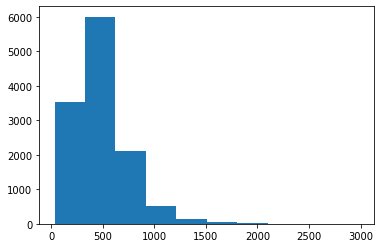

In [31]:
directions_len=df["Directions"].apply(len)
print(directions_len[:20])
plt.hist(directions_len)

In [35]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
inf

In [ ]:
dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "tags": []
    }

    